**<font size = 4> <font color = 'red'> IMPORT MODULES**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

**<font size = 4> <font color = 'red'> READ IN MATCHUP DATA**

In [ ]:
nba_series = pd.read_csv("TEAM_MATCHUP_DATA_FINAL.csv") # replace with your path
nba_series['SEASON'] = nba_series['SEASON'].astype(int)

**<font size = 4> <font color = 'red'> SET UP TRAIN/TEST DATA**

In [ ]:
# Trained on data from 1997-2023 and tested on 2024 data
train_data_gen = nba_series[nba_series['SEASON'] < 2024]
test_data_gen = nba_series[nba_series['SEASON'] == 2024]

# Separate out the columns to keep for comparison
columns_to_keep = ['SERIES_ID', 'SEASON', 'TEAM_1', 'TEAM_2', 'SERIES_WINNER']
# Save the original data with the columns to keep
train_data_preserved = train_data_gen[columns_to_keep]
test_data_preserved = test_data_gen[columns_to_keep]

# Drop columns before training the model
nba_series = nba_series.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])
train_data_gen = train_data_gen.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])
test_data_gen = test_data_gen.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])

# Set up the target variable as TEAM_1_W and drop TEAM_1, TEAM_2, and SERIES_WINNER variables
nba_series['TEAM_1_W'] = (nba_series['SERIES_WINNER'] == nba_series['TEAM_1']).astype(int)
nba_series = nba_series.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])

train_data_gen['TEAM_1_W'] = (train_data_gen['SERIES_WINNER'] == train_data_gen['TEAM_1']).astype(int)
train_data_gen = train_data_gen.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])

test_data_gen['TEAM_1_W'] = (test_data_gen['SERIES_WINNER'] == test_data_gen['TEAM_1']).astype(int)
test_data_gen = test_data_gen.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])

In [ ]:
tf.keras.backend.clear_session()


**<font size = 4> <font color = 'red'> NEURAL NETWORK TRAINING/TESTING (FULL DATA)**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5557 - loss: 0.6992 - val_accuracy: 0.5820 - val_loss: 0.6731
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5920 - loss: 0.6743 - val_accuracy: 0.6402 - val_loss: 0.6544
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6407 - loss: 0.6345 - val_accuracy: 0.6667 - val_loss: 0.5966
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6929 - loss: 0.5937 - val_accuracy: 0.7249 - val_loss: 0.5833
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7615 - loss: 0.5072 - val_accuracy: 0.7407 - val_loss: 0.5514
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7949 - loss: 0.4539 - val_accuracy: 0.7513 - val_loss: 0.5609
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8093 - loss: 0.4489 - val_accuracy: 0.7831 - val_loss: 0.5019
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8787 - loss: 0.3559 - val_accuracy: 0.7937 - v

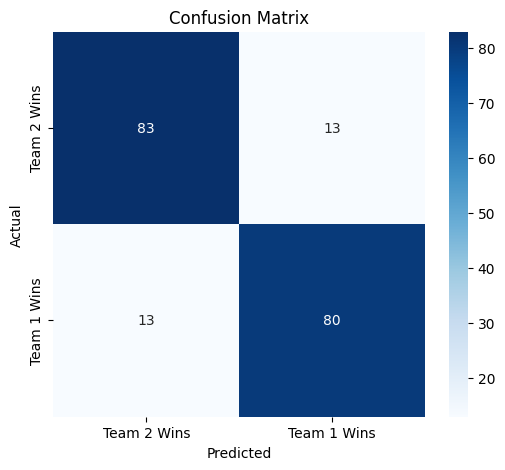

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


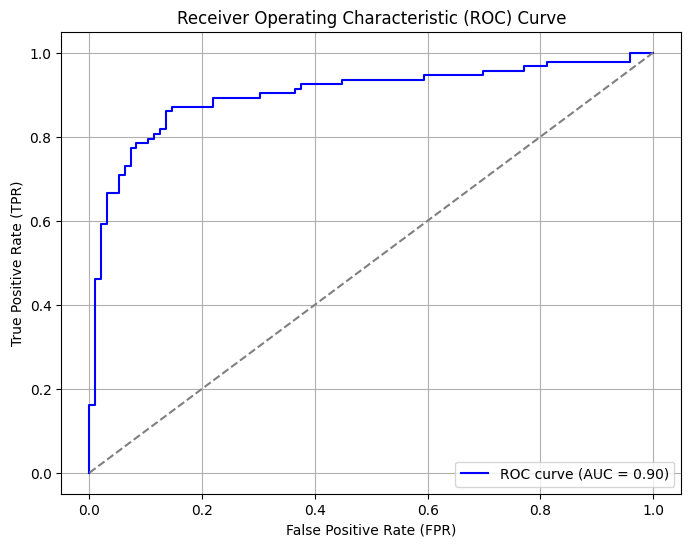

In [ ]:
# Load the dataset (nba_series) and separate features (X) and target (y)
X = nba_series.drop(columns=['TEAM_1_W'])
y = nba_series['TEAM_1_W']

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Standardize the features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_dim=X_train.shape[1]),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    #kernel_regularizer=tf.keras.regularizers.l2(0.01)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    class_weight=class_weight_dict, callbacks=[early_stopping])

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Evaluate the model
print(f"Model Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Team 2 Wins', 'Team 1 Wins'],
            yticklabels=['Team 2 Wins', 'Team 1 Wins'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Get the predicted probabilities for the positive class (Team 1 Wins)
y_prob = model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
tf.keras.backend.clear_session()


**<font size = 4> <font color = 'red'> NEURAL NETWORK TRAINING (1997-2004), TESTING (2005)**

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9253 - loss: 0.2743 - val_accuracy: 0.8667 - val_loss: 0.3551
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9032 - loss: 0.2490 - val_accuracy: 0.8667 - val_loss: 0.3294
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9051 - loss: 0.2209 - val_accuracy: 0.8000 - val_loss: 0.4353
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8871 - loss: 0.2428 - val_accuracy: 0.8667 - val_loss: 0.2619
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9221 - loss: 0.2114 - val_accuracy: 0.8667 - val_loss: 0.4818
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9230 - loss: 0.2014 - val_accuracy: 0.8000 - val_loss: 0.3094
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9276 - loss: 0.2015 - val_accuracy: 0.6667 - val_loss: 0.5539
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9316 - loss: 0.1573 - val_accuracy: 0.8000 - v

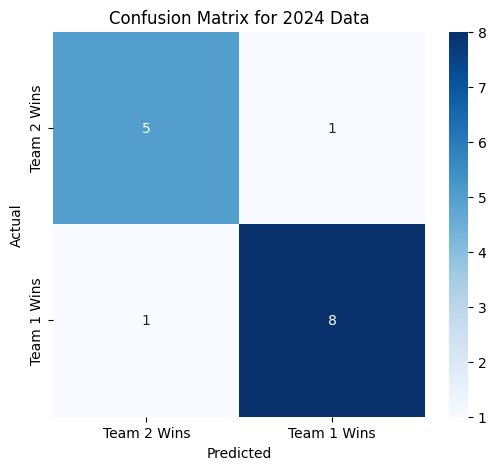

In [ ]:
# Make predictions on the 2016 data
# Assuming you have already split into 1997-2023 (training) & 2024 (testing)
X_train_gen = train_data_gen.drop(columns=['TEAM_1_W'])
y_train_gen = train_data_gen['TEAM_1_W']
X_test_gen = test_data_gen.drop(columns=['TEAM_1_W'])
y_test_gen = test_data_gen['TEAM_1_W']

# Standardize the features for 2024 data
X_train_gen = scaler.transform(X_train_gen)
X_test_gen = scaler.transform(X_test_gen)

# Train the model
model.fit(X_train_gen, y_train_gen, epochs=50, batch_size=32, validation_data=(X_test_gen, y_test_gen),
          class_weight=class_weight_dict, callbacks=[early_stopping])

# Make predictions on the 2024 test data
y_pred_gen = (model.predict(X_test_gen) > 0.5).astype("int32")

# Evaluate the model on 2024 data
print(f"Accuracy on 2024 data: {accuracy_score(y_test_gen, y_pred_gen) * 100:.2f}%")
print("\nClassification Report for 2024 data:")
print(classification_report(y_test_gen, y_pred_gen))

# Confusion matrix for 2024 data
cm_24 = confusion_matrix(y_test_gen, y_pred_gen)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_24, annot=True, fmt='d', cmap='Blues', xticklabels=['Team 2 Wins', 'Team 1 Wins'],
            yticklabels=['Team 2 Wins', 'Team 1 Wins'])
plt.title('Confusion Matrix for 2024 Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
tf.keras.backend.clear_session()



**<font size = 4> <font color = 'red'> DISPLAY FINAL RESULTS**

In [ ]:
test_data_preserved['PRED_WINNER'] = y_pred_gen
test_data_preserved

,SERIES_ID,SEASON,TEAM_1,TEAM_2,SERIES_WINNER,PRED_WINNER
405,2024_BOS_CLE,2024,Boston Celtics,Cleveland Cavaliers,Boston Celtics,1
406,2024_BOS_DAL,2024,Boston Celtics,Dallas Mavericks,Boston Celtics,1
407,2024_BOS_IND,2024,Boston Celtics,Indiana Pacers,Boston Celtics,1
408,2024_BOS_MIA,2024,Boston Celtics,Miami Heat,Boston Celtics,1
409,2024_CLE_ORL,2024,Cleveland Cavaliers,Orlando Magic,Cleveland Cavaliers,0
410,2024_DAL_LAC,2024,LA Clippers,Dallas Mavericks,Dallas Mavericks,0
411,2024_DAL_MIN,2024,Minnesota Timberwolves,Dallas Mavericks,Dallas Mavericks,1
412,2024_DAL_OKC,2024,Oklahoma City Thunder,Dallas Mavericks,Dallas Mavericks,0
413,2024_DEN_LAL,2024,Denver Nuggets,Los Angeles Lakers,Denver Nuggets,1
414,2024_DEN_MIN,2024,Denver Nuggets,Minnesota Timberwolves,Minnesota Timberwolves,0


In [ ]:
tf.keras.backend.clear_session()



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

# ... (rest of your data loading and preprocessing code) ...

# Prepare data for k-fold cross-validation
X = np.array(train_data_gen.drop(columns=['TEAM_1_W'])) # Convert to NumPy array
y = np.array(train_data_gen['TEAM_1_W']) # Convert to NumPy array

# Initialize k-fold cross-validation
n_splits = 5 # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store results for each fold
accuracy_scores = []
classification_reports = []
confusion_matrices = []
auc_scores = []

# Iterate through folds
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}/{n_splits}")

    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Apply SMOTE to the training set for this fold
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_fold, y_train_fold = smote.fit_resample(X_train_fold, y_train_fold)

    # Standardize features using StandardScaler on the current fold's data
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)


    # Build the neural network model


    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Set up early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Compute class weights for this fold
    class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train_fold)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Train the model for this fold
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32,
              validation_data=(X_val_fold, y_val_fold),
              class_weight=class_weight_dict, callbacks=[early_stopping])

    # Make predictions on the validation set for this fold
    y_pred_fold = (model.predict(X_val_fold) > 0.5).astype("int32")
    auc_score_fold = roc_auc_score(y_val_fold, y_pred_fold)
    auc_scores.append(auc_score_fold)


    # Evaluate the model for this fold
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred_fold))
    classification_reports.append(classification_report(y_val_fold, y_pred_fold))
    confusion_matrices.append(confusion_matrix(y_val_fold, y_pred_fold))

# Print average results across all folds
print("\nAverage Accuracy:", np.mean(accuracy_scores))
print("\nAverage Classification Report:\n", classification_reports[0]) # Print one example report
print("\nAverage Confusion Matrix:\n", np.mean(confusion_matrices, axis=0))
print("\nAverage AUC Score:", np.mean(auc_scores))  # Print average AUC score

Fold 1/5
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9392 - loss: 0.2017 - val_accuracy: 0.9136 - val_loss: 0.2375
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9646 - loss: 0.1181 - val_accuracy: 0.9012 - val_loss: 0.2700
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9353 - loss: 0.1547 - val_accuracy: 0.9136 - val_loss: 0.2100
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9506 - loss: 0.1524 - val_accuracy: 0.9383 - val_loss: 0.2087
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9721 - loss: 0.0995 - val_accuracy: 0.9259 - val_loss: 0.2405
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9390 - loss: 0.1437 - val_accuracy: 0.9012 - val_loss: 0.2280
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9561 - loss: 0.1218 - val_accuracy: 0.8765 - val_loss: 0.3464
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9475 - loss: 0.1199 - val_accuracy: 0